##Устанавливаем необходимые пакеты и библиотеки

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
BiocManager::install("DESeq2")

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.2 (2023-10-31)

Installing package(s) 'BiocVersion', 'DESeq2'

also installing the dependencies ‘bitops’, ‘formatR’, ‘RCurl’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘GenomeInfoDb’, ‘XVector’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase’, ‘BiocParallel’, ‘matrixStats’, ‘locfit’, ‘Rcpp’, ‘MatrixGenerics’, ‘RcppArmadillo’


Old packages: 'bit', 'bslib', 'curl', 'devtools', 'dplyr', 'gargle', 'highr',
  'httr2', 'isoband', 'openssl', 'ragg', 'roxygen2', 'stringi', 'stringr',
  'textshaping', 'tinytex', 'whisker', 'boot', 'Matrix'



In [3]:
install.packages("pheatmap")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:
library("DESeq2")
library("pheatmap")

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

##Считываем файл с чтениями в info и преобразуем в матрицу в counts

In [77]:
counts <- as.matrix(read.table("ALL.counts", header=TRUE))
info   <- read.table("ALL(6).info", header=TRUE)

dds <- DESeqDataSetFromMatrix(countData = counts, colData = info, design = ~ condition)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [78]:
head(info)

,id,condition
,<chr>,<chr>
c1,SRR3414635,control
c2,SRR3414636,control
c3,SRR3414637,control
r1,SRR3414629,reprogramming
r2,SRR3414630,reprogramming
r3,SRR3414631,reprogramming


In [79]:
head(counts)

c1,c2,c3,r1,r2,r3
3466,3532,4078,4507,3964,5757
0,0,0,0,0,0
152,137,152,348,275,472
55721,48392,56187,64722,33333,65188
43,44,53,79,70,92
10,8,11,4,1,1


##С помощью DESeq получаем в res таблицу с дифференуциально экспрессированными генами

In [68]:
# Tell the DDS which columns correspond to the 'reference' level of gene expression
dds$condition <- relevel(dds$condition, ref="control")

dds <- DESeq(dds)
res <- results(dds, alpha=0.01)   # Specify a more strict threshold on padj. This threshold is called 'alpha'


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



##Строим Heatmap для уровня экспрессии образцов и еще один график с дифференциально экспрессированными генами

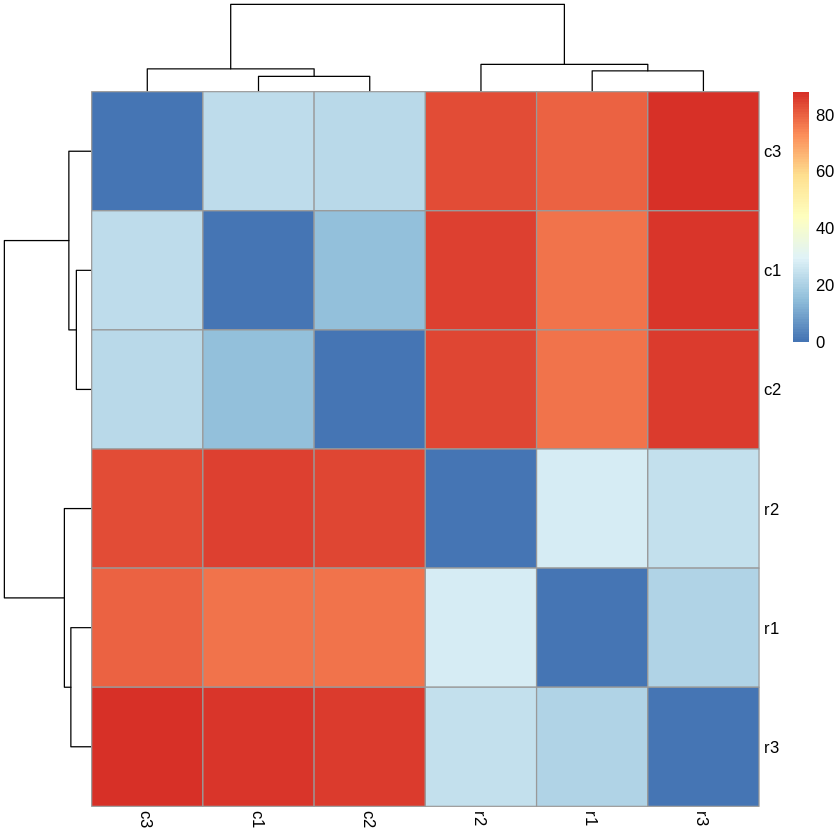

In [69]:
rld <- rlog(dds)
sampleDists <- dist(t(assay(rld)))
sampleDistMatrix <- as.matrix(sampleDists)
pheatmap(sampleDistMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists)


In [70]:
resOrdered <- res[order(res$padj),]
resSignificant <- subset(resOrdered, padj < 0.01)
write.table(resSignificant, "differentially_expressed_genes.txt", sep="\t", row.names=TRUE, quote = FALSE)

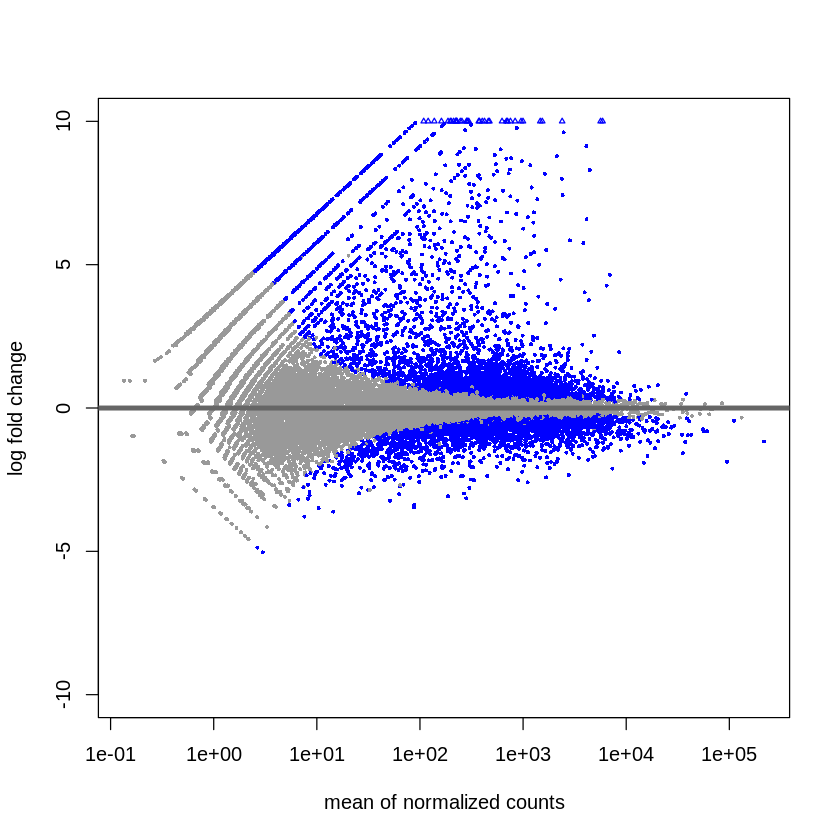

In [71]:
plotMA(res, ylim=c(-10,10))

##И еще один Heatmap с условиями для дифференциально экспрессированных генов

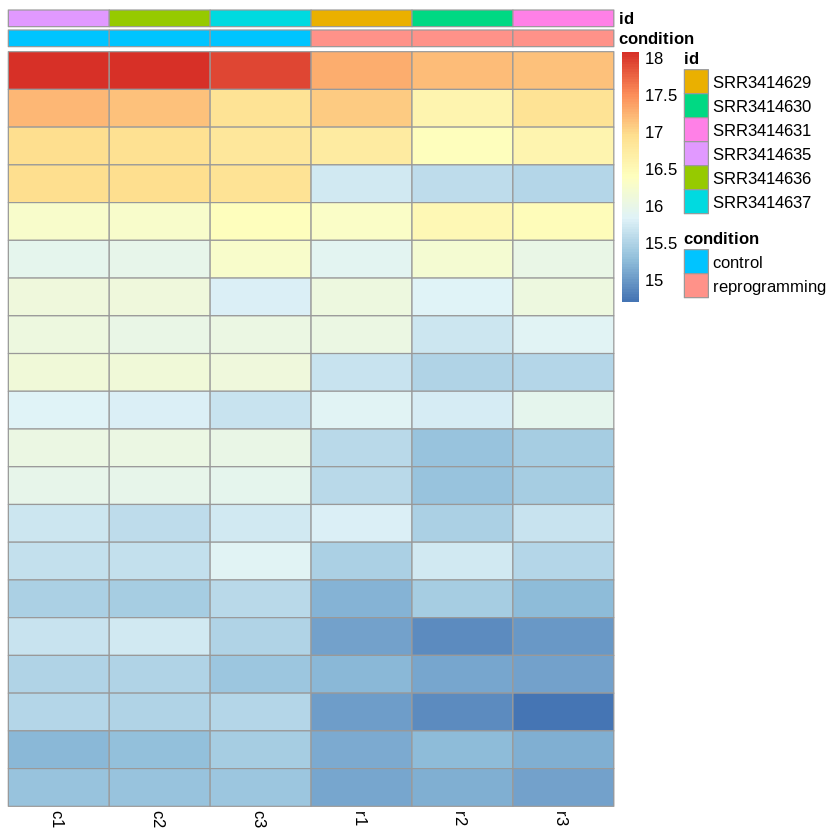

In [72]:
select <- order(rowMeans(counts(dds,normalized=TRUE)),decreasing=TRUE)[1:20]
df <- as.data.frame(colData(dds)[,c("condition","id")])
pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE,cluster_cols=FALSE, annotation_col=df)


##И на графиках еще проверим, действительно ли гены являются дифференциально экспрессированными (отображаем два условия и смотрим на число счетов)

log2 fold change (MLE): condition reprogramming vs control 
Wald test p-value: condition reprogramming vs control 
DataFrame with 1 row and 6 columns
   baseMean log2FoldChange     lfcSE      stat       pvalue         padj
  <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
1   5647.17        11.8829  0.493665   24.0708 5.06065e-128 2.05373e-125

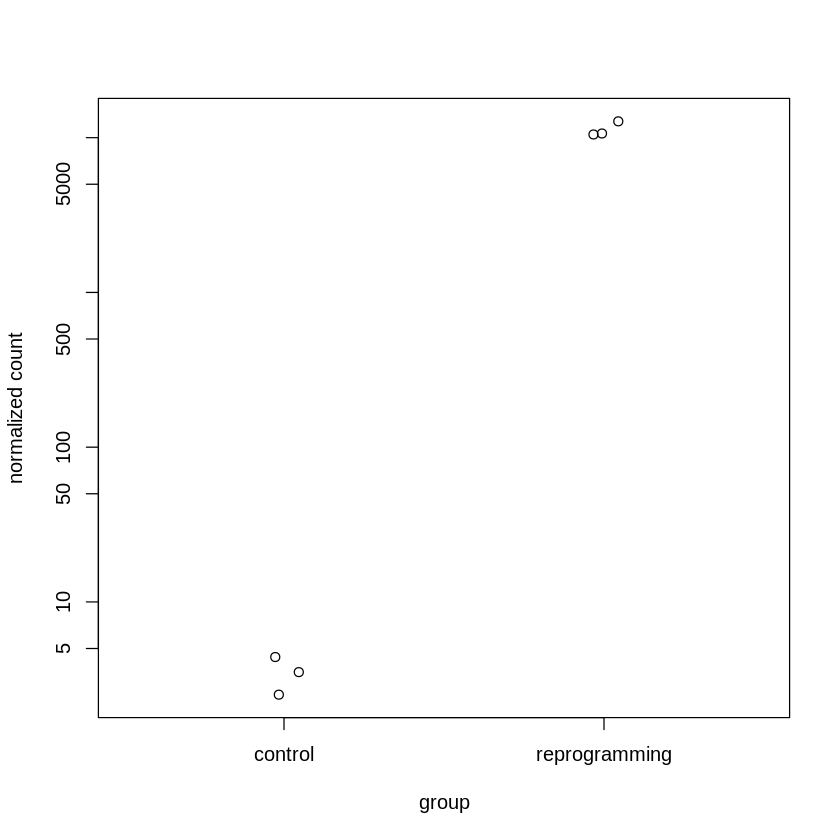

In [73]:
res[10072,]
plotCounts(dds, gene=10072, intgroup="condition")

log2 fold change (MLE): condition reprogramming vs control 
Wald test p-value: condition reprogramming vs control 
DataFrame with 1 row and 6 columns
   baseMean log2FoldChange     lfcSE      stat      pvalue        padj
  <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
1   422.308        12.1686   1.18742    10.248 1.20858e-24 3.11507e-23

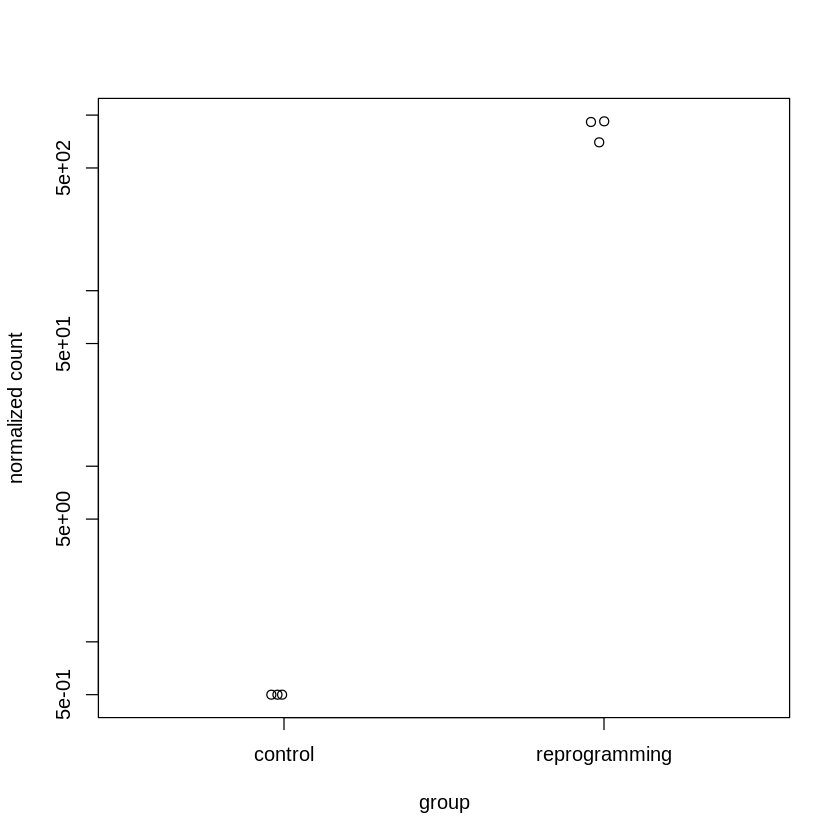

In [74]:
res[12032,]
plotCounts(dds, gene=12032, intgroup="condition")

log2 fold change (MLE): condition reprogramming vs control 
Wald test p-value: condition reprogramming vs control 
DataFrame with 1 row and 6 columns
   baseMean log2FoldChange     lfcSE      stat      pvalue        padj
  <numeric>      <numeric> <numeric> <numeric>   <numeric>   <numeric>
1   297.237        11.6622   1.19426   9.76522 1.58762e-22 3.62682e-21

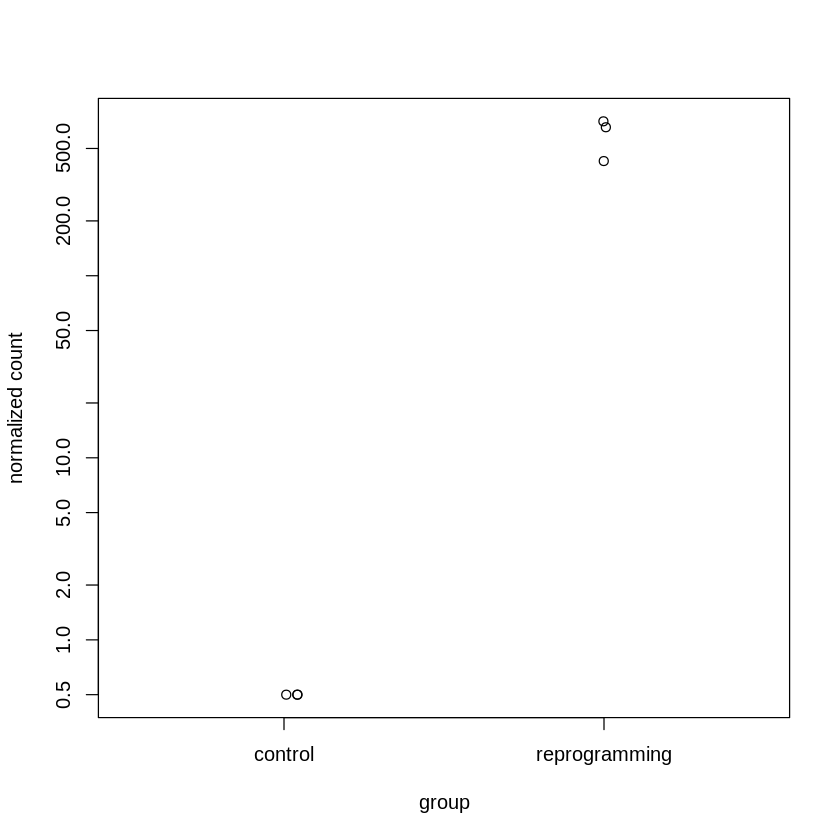

In [75]:
res[13630,]
plotCounts(dds, gene=13630, intgroup="condition")

В итоге видим, что получились сильно разбросанные точки у контрольных и перепрограммированых генов